#Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install scikit_ued inpystem

     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 122kB 23.7MB/s 
     |████████████████████████████████| 225kB 33.7MB/s 
     |████████████████████████████████| 133kB 48.9MB/s 
     |████████████████████████████████| 26.6MB 113kB/s 
     |████████████████████████████████| 1.1MB 39.9MB/s 
     |████████████████████████████████| 296kB 62.7MB/s 
     |████████████████████████████████| 18.1MB 200kB/s 
     |████████████████████████████████| 450kB 56.2MB/s 
     |████████████████████████████████| 204kB 41.3MB/s 
     |████████████████████████████████| 194kB 58.8MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for hyperspy: filename=hyperspy-1.5.2-cp36-cp36m-linux_x86_64.whl size=27913544 sha256=4a591cbe831257320dd32d5ecdd73b5656ce04c97f3f8e9bec7a9919cc87bbad
  Stored in directory: /root/.cache/pip/wheels/0e/b1/dc/f98ce087fe06ce5ad2e145458bf638fec321b028e95d4d4901
  Created wheel for pycifrw: filename=PyCifRW-4.4.1-cp3

In [3]:
%cd '/content/drive/My Drive'

/content/drive/My Drive


In [4]:
#uncomment this line if first run
#!git clone https://github.com/vcoyette/eels-inpainting-team8.git

%cd eels-inpainting-team8/

/content/drive/My Drive/deep-image-prior


# Import libs

In [5]:
from helper import *

%matplotlib inline

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

WARNING - hyperspy.api - The ipywidgets GUI elements are not available, probably because the hyperspy_gui_ipywidgets package is not installed."
WARNING - hyperspy.api - The traitsui GUI elements are not available, probably because the hyperspy_gui_traitsui package is not installed."


#Load data

Run some of the cells below to work on train (EELS or plane) or test data.

In [0]:
do_pca = True
img_percentage = 0.2
number_principal_components = 20

## Training data

In [0]:
path_list = ['data/HR-sample/spim4-2_ali.dm4', 'ata/HR-Spim5-Mul/spim5-Mul-600.dm4', 
             'data/HR-Spim08-Ca/180118_Spim08_Ca_poor_topfilm_Spim.dm3', 'data/HR-Spim19-Fe/190718_Spim19_Fe_grain_topfilm.dm3']

Image loaded with success !
Mask created with success !
Both PCA done with success !
Both weights calculated with success !


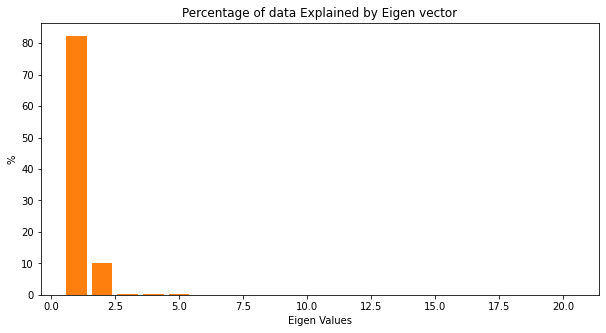

In [8]:
full_pca_img, partial_pca_img, mask, _, _, PCA_orig, PCA = load_and_process_fc(path_list[0],number_principal_components,img_percentage)

is_test = False

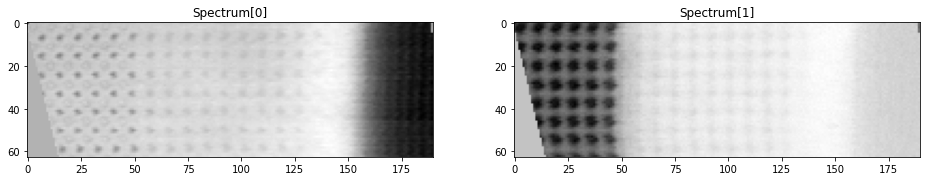

In [9]:
f = plot_spectre(full_pca_img)

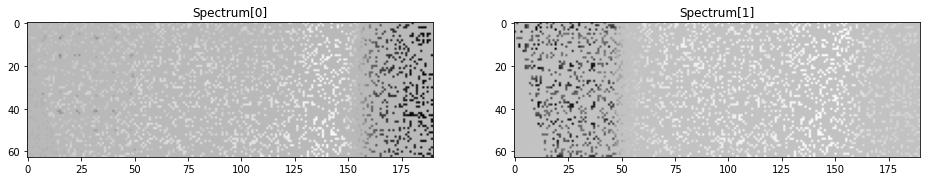

In [10]:
f = plot_spectre(partial_pca_img)

## Plane image (training)

In [11]:
full_pca_img, img_rgb, partial_pca_img, mask, PCA_orig, PCA = load_aviris(img_percentage, do_pca, number_principal_components)

is_test = False

Image loaded with success !
RGB-Image created with success !
Mask created with success !
Both PCA done with success !


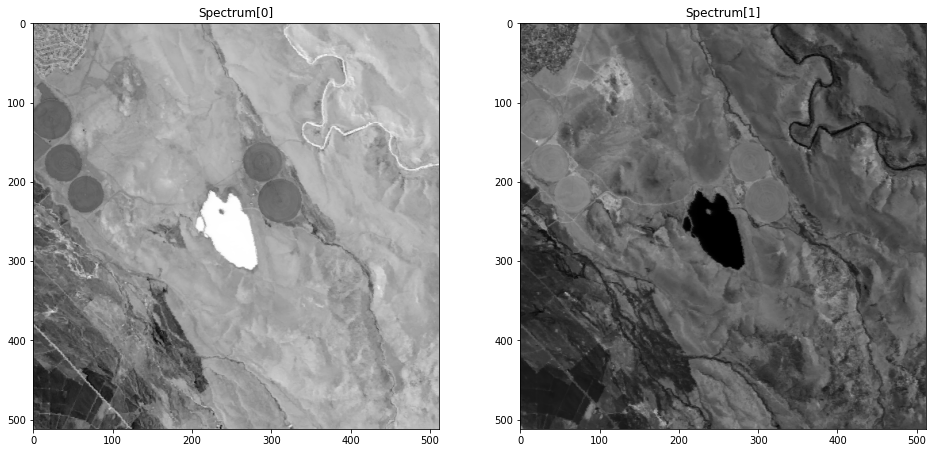

In [12]:
f = plot_spectre(full_pca_img)

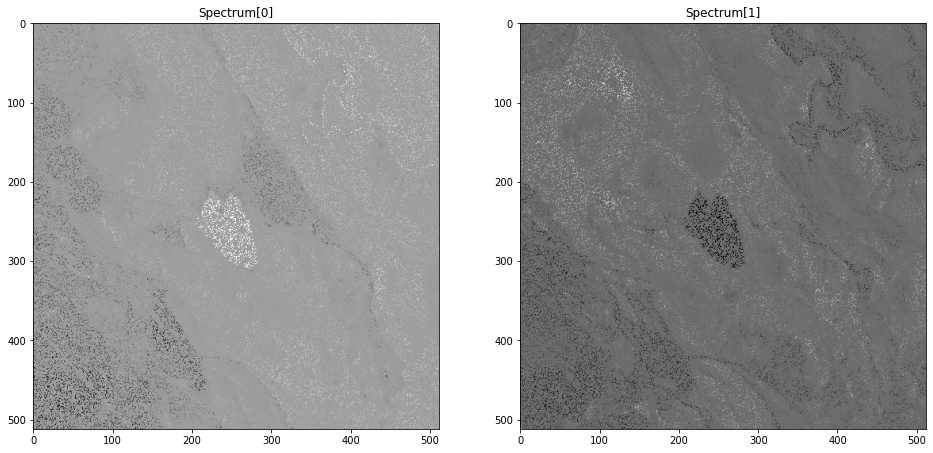

In [13]:
f = plot_spectre(partial_pca_img)

## Test data

In [0]:
test_img, partial_pca_img, mask, PCA, mfi, mmfi = load_and_process_test_image(number_principal_components)

is_test = True

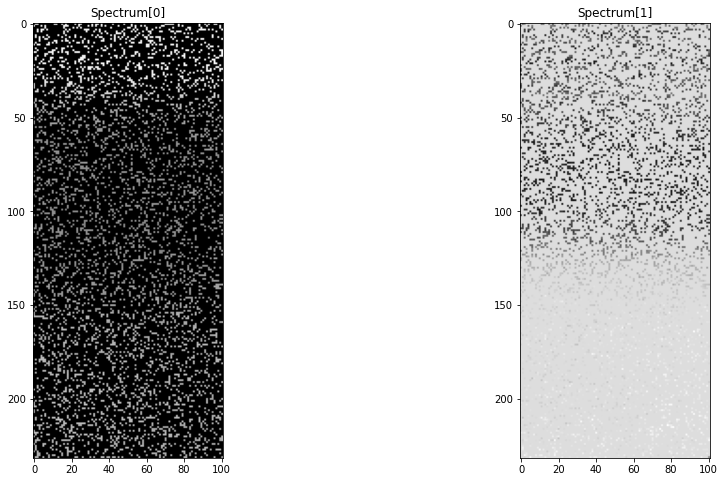

In [15]:
f = plot_spectre(partial_pca_img)

#Training

In [0]:
input_depth = partial_pca_img.shape[0]
output_depth = partial_pca_img.shape[0]

## Hyperparameters

In [0]:
num_iter = 3001
show_every = 100
reg_noise_std = 0.01

loss_name = 'master_metric' # one of 'mse'|'master_metric'
NET_TYPE = 'resnet' # one of skip_depth4|skip_depth2|resnet
OPTIMIZER = 'adamw' # one of 'adam'|'adamw'
pad = 'zero' 

LR = 0.01

grad_clipping = True # True or False

resnet_num_blocks = 16
resnet_num_channels = 32

Feel free to tweak some parameters below.

In [0]:
if 'skip' in NET_TYPE:
    
    depth = int(NET_TYPE[-1])
    net = skip(input_depth, output_depth, 
            num_channels_down = [64, 64, 64][:depth],
            num_channels_up =   [64, 64, 64][:depth],
            num_channels_skip =    [16, 16, 16][:depth],  
            filter_size_up = 5,filter_size_down = 5,  filter_skip_size=1,
            upsample_mode='nearest', # downsample_mode='avg',
            need1x1_up=False,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif NET_TYPE == 'resnet':
    
    net = ResNet(input_depth, output_depth, resnet_num_blocks, resnet_num_channels, act_fun='LeakyReLU')

else:
    raise ValueError("Select an architecture among skip_depth6 | skip_depth4 skip_depth2 | resnet")

## Let's go

In [14]:
(ssim, psnr, sad), time_elapsed, out_np = train(net, partial_pca_img, mask, OPTIMIZER, loss_name, num_iter, grad_clipping, LR, reg_noise_std, show_every)

Output hidden; open in https://colab.research.google.com to view.

Seconds elapsed : 122 
Inverse PCA done with success !
Restored Summed Image


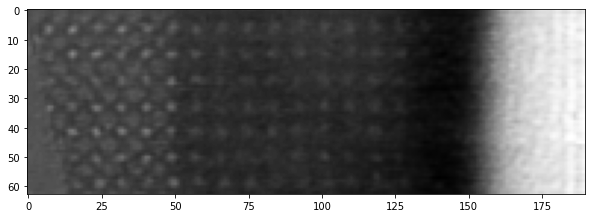

In [15]:
if is_test:
    restored = results(out_np, time_elapsed, PCA, is_test=is_test)
    print('Restored Summed Image')
    plt.imshow(restored)
if not is_test:
    restored , orig = results(out_np, time_elapsed, PCA, is_test, full_pca_img)
    print('Restored Summed Image')
    plt.imshow(restored)

Original Summed Image


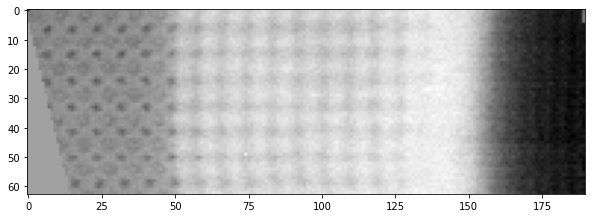

In [16]:
if not is_test:
    print('Original Summed Image')
    plt.imshow(orig)